**Open in Colab**  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsg213/highway-env/blob/master/high_env.ipynb)

Run the two following sections to have the local environment ready

# 1.Cloning repo and installing libraries

In [1]:
!git clone https://github.com/gsg213/highway-env
!pip install pygame
!pip install stable_baselines3 
!pip install cloudpickle==2.0 --upgrade

Cloning into 'highway-env'...
remote: Enumerating objects: 8315, done.
remote: Counting objects: 100% (781/781), done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 8315 (delta 449), reused 606 (delta 361), pack-reused 7534
Receiving objects: 100% (8315/8315), 43.89 MiB | 33.10 MiB/s, done.
Resolving deltas: 100% (5645/5645), done.
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 174 kB 5.1 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.


In [2]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!git clone https://github.com/eleurent/highway-env.git
!apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay


  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.0.0
    Uninstalling cloudpickle-2.0.0:
      Successfully uninstalled cloudpickle-2.0.0
fatal: destination path 'highway-env' already exists and is not an empty directory.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-update

In [3]:
import sys
sys.path.insert(0,'/content/highway-env/highway_env')
sys.path.append('/content/highway-env')
sys.path.insert(0, '/content/highway-env/scripts')
from utils import record_videos, show_videos
import os
os.environ['SDL_VIDEODRIVER']='dummy'


In [4]:
%%shell
cd highway-env/

# 2.Register environment

In [5]:

from typing import Tuple

from gym.envs.registration import register
import numpy as np
import os
from highway_env import utils
from highway_env.envs.common.abstract import AbstractEnv #
from highway_env.road.lane import LineType, StraightLane, CircularLane, SineLane,AbstractLane
from highway_env.road.road import Road, RoadNetwork
from highway_env.vehicle.controller import MDPVehicle


class RoundaboutEnv(AbstractEnv):

    @classmethod
    def default_config(cls) -> dict:
        config = super().default_config()
        config.update({
            "observation": {
                "type": "Kinematics",
                "absolute": True,
                "features_range": {"x": [-200, 200], "y": [-200, 200], "vx": [-15, 15], "vy": [-15, 15],"roundabout":[0,5]},
            },
            "action": {
                "type": "DiscreteMetaAction",
            },
            "incoming_vehicle_destination": 2,
            "collision_reward": -1,
            "high_speed_reward": 0.7,
            "right_lane_reward": 0.1,
            "lane_change_reward": -0.05,
            "screen_width": 1000,
            "screen_height": 1000,
            "centering_position": [0.5, 0.6],
            "duration": 25
        })
        return config

    def _reward(self, action: int) -> float:
        lane_change = action == 0 or action == 2
        reward = self.config["collision_reward"] * self.vehicle.crashed \
            + self.config["high_speed_reward"] * \
                 MDPVehicle.get_speed_index(self.vehicle) / max(MDPVehicle.SPEED_COUNT - 1, 1) \
            + self.config["lane_change_reward"] * lane_change
        return utils.lmap(reward,
                          [self.config["collision_reward"] + self.config["lane_change_reward"],
                           self.config["high_speed_reward"]], [0, 1])

    def _is_terminal(self) -> bool:
        """The episode is over when a collision occurs or when the access ramp has been passed."""
        return self.vehicle.crashed or self.steps >= self.config["duration"]

    def _reset(self) -> None:
        self._make_road()
        self._make_vehicles()

    def _make_road(self) -> None:
        # Circle lanes: (s)outh/(e)ast/(n)orth/(w)est (e)ntry/e(x)it.
        center = [0, 0]  # [m]
        radius = 20  # [m]
        alpha = 24  # [deg]

        net = RoadNetwork()
        radii = [radius, radius+4 ,radius+8.2]
        n, c, s = LineType.NONE, LineType.CONTINUOUS, LineType.STRIPED
        line = [[c, s],[s, s] ,[n, c]]
        for lane in [0, 1, 2]:
            # Círculo derecha inferior 
            net.add_lane("se", "ex",
                          CircularLane(center, radii[lane], np.deg2rad(90 - alpha), np.deg2rad(alpha),
                                      clockwise=False, line_types=line[lane]))
            # # Círculo derecha
            net.add_lane("ex", "ee",
                          CircularLane(center, radii[lane], np.deg2rad(alpha), np.deg2rad(-alpha),
                                      clockwise=False, line_types=line[lane]))
            # Circulo superior derecho
            net.add_lane("ee", "nx",
                          CircularLane(center, radii[lane], np.deg2rad(-alpha), np.deg2rad(-90 + alpha),
                                      clockwise=False, line_types=line[lane]))
            # Círculo superior
            net.add_lane("nx", "ne",
                          CircularLane(center, radii[lane], np.deg2rad(-90 + alpha), np.deg2rad(-90 - alpha),
                                      clockwise=False, line_types=line[lane]))
            # Círdulo izquierda inferior
            net.add_lane("ne", "wx",
                          CircularLane(center, radii[lane], np.deg2rad(-90 - alpha), np.deg2rad(-180 + alpha),
                                      clockwise=False, line_types=line[lane]))
            #  Círculo superior izquieda
            net.add_lane("wx", "we",
                          CircularLane(center, radii[lane], np.deg2rad(-180 + alpha), np.deg2rad(-180 - alpha),
                                      clockwise=False, line_types=line[lane]))
            #  Círulo izquierda
            net.add_lane("we", "sx",
                          CircularLane(center, radii[lane], np.deg2rad(180 - alpha), np.deg2rad(90 + alpha),
                                      clockwise=False, line_types=line[lane]))
            # # Círculo inferior 
            net.add_lane("sx", "se",
                         CircularLane(center, radii[lane], np.deg2rad(90 + alpha), np.deg2rad(90 - alpha),
                                      clockwise=False, line_types=line[lane]))

        # Access lanes: (r)oad/(s)ine
        access = 170  # [m]
        dev = 100  # [m] 85
        a =  2 # [m]
        delta_st = 0.2*dev  # [m]

        delta_en = dev-delta_st
        w = 2*np.pi/dev
        # acces,
        # net.add_lane("ser", "ses", StraightLane([2, access], [2, dev/2], line_types=(s, c))) #dev en 120
        net.add_lane("ses", "se", SineLane([2+a, dev/2], [2+a, dev/2-delta_st], a, w, -np.pi/2, line_types=(s, s)))
        net.add_lane("ser", "ses", StraightLane([2, access], [2, dev/2], line_types=(s, n))) #dev en 120
        net.add_lane("ses", "se", SineLane([2+a, dev/2], [2+a, dev/2-delta_st], a, w, -np.pi/2, line_types=(s, n)))
        
        
        net.add_lane("ser", "ses", StraightLane([2+4, access], [2+4, (dev)/2], line_types=(s, c))) #dev en 120
        net.add_lane("ses", "se", SineLane([2+a+4, (dev)/2], [2+a+4, (dev)/2-delta_st], a, w+.01, -np.pi/2, line_types=(n, c)))
    
        net.add_lane("sx", "sxs", SineLane([-2-a, -dev/2+delta_en], [-2-a, dev/2], a, w, -np.pi/2+w*delta_en, line_types=(s, c)))
        net.add_lane("sxs", "sxr", StraightLane([-2, dev / 2], [-2, access], line_types=(n, c)))


        net.add_lane("eer", "ees", StraightLane([access, -2], [dev / 2, -2], line_types=(s, s)))
        net.add_lane("ees", "ee", SineLane([dev / 2, -2-a], [dev / 2 - delta_st, -2-a], a, w, -np.pi / 2, line_types=(c, c)))
        net.add_lane("ex", "exs", SineLane([-dev / 2 + delta_en, 2+a], [dev / 2, 2+a], a, w, -np.pi / 2 + w * delta_en, line_types=(c, c)))
        net.add_lane("exs", "exr", StraightLane([dev / 2, 2], [access, 2], line_types=(n, c)))

        net.add_lane("ner", "nes", StraightLane([-2, -access], [-2, -dev / 2], line_types=(s, c)))
        net.add_lane("nes", "ne", SineLane([-2 - a, -dev / 2], [-2 - a, -dev / 2 + delta_st], a, w, -np.pi / 2, line_types=(c, c)))
        net.add_lane("nx", "nxs", SineLane([2 + a, dev / 2 - delta_en], [2 + a, -dev / 2], a, w, -np.pi / 2 + w * delta_en, line_types=(c, c)))
        net.add_lane("nxs", "nxr", StraightLane([2, -dev / 2], [2, -access], line_types=(n, c)))

        net.add_lane("wer", "wes", StraightLane([-access, 2], [-dev / 2, 2], line_types=(s, c)))
        net.add_lane("wes", "we", SineLane([-dev / 2, 2+a], [-dev / 2 + delta_st, 2+a], a, w, -np.pi / 2, line_types=(c, c)))
        net.add_lane("wx", "wxs", SineLane([dev / 2 - delta_en, -2-a], [-dev / 2, -2-a], a, w, -np.pi / 2 + w * delta_en, line_types=(c, c)))
        net.add_lane("wxs", "wxr", StraightLane([-dev / 2, -2], [-access, -2], line_types=(n, c)))

        #Intersection
        
        lane_width = AbstractLane.DEFAULT_WIDTH
        right_turn_radius = lane_width + 5  # [m}
        left_turn_radius = right_turn_radius + lane_width  # [m}
        outer_distance = right_turn_radius + lane_width / 2
        access_length = 50 + 50 # [m]
        angle = np.radians(90 * 3)
        is_horizontal = 3 % 2
        priority = 3 if is_horizontal else 1
        rotation = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        corner = 3
        #net = RoadNetwork()
        #n, c, s = LineType.NONE, LineType.CONTINUOUS, LineType.STRIPED
        
        #Curves of the intersection
        net.add_lane("ir" + str(3), "il" + str((3 - 1) % 4),
                      CircularLane(np.array([-170, -11]),#r_center, 
                                  right_turn_radius, angle + np.radians(180), angle + np.radians(270),
                                  line_types=[n, c], priority=priority, speed_limit=10))
        
        net.add_lane("ir" + str(3), "il" + str((3 - 1) % 4),
                      CircularLane(np.array([-192, -11]),#r_center, 
                                  right_turn_radius, angle + np.radians(90), angle + np.radians(180),
                                  line_types=[n, c], priority=priority, speed_limit=10))
        
        net.add_lane("ir" + str(3), "il" + str((3 - 1) % 4),
                      CircularLane(np.array([-169, 11]),#r_center, 
                                  right_turn_radius, angle + np.radians(270), angle + np.radians(360),
                                  line_types=[n, c], priority=priority, speed_limit=10))
        
        net.add_lane("ir" + str(3), "il" + str((3 - 1) % 4),
                      CircularLane(np.array([-192, 11]),#r_center, 
                                  right_turn_radius, angle + np.radians(0), angle + np.radians(90),
                                  line_types=[n, c], priority=priority, speed_limit=10))
        
            # Incoming
        rotation = np.array([[np.cos(np.radians(90 * 3)), -np.sin(np.radians(90 * 3))], [np.sin(np.radians(90 * 3)), np.cos(np.radians(90 * 3))]])
        start = rotation @ np.array([lane_width / 2, access_length + outer_distance])
        end = rotation @ np.array([lane_width / 2, outer_distance])
        #Intersection superior
        #i: intersection
        #inir:intersection north initial right
        #infr:intersection north final right
        #inir:intersection north initial left
        #infr:intersection north final left
        net.add_lane("inir", "infr",
                          StraightLane([-179,-10.5],[-179, -110], line_types=[s, c], priority=priority, speed_limit=10))
        
        net.add_lane("inil" , "infl" ,
                          StraightLane([-183,-10.5],[-183, -110], line_types=[c, n], priority=priority, speed_limit=10))
        
        #Intersection inferior
        #inir:intersection south initial right
        #infr:intersection south final right
        #inir:intersection south initial left
        #infr:intersection south final left
        net.add_lane("isil", "isfl",
                          StraightLane([-183,10.5],[-183, 110], line_types=[s, c], priority=priority, speed_limit=10))
        
        net.add_lane("isir", "isfr",
                          StraightLane([-178,10.5],[-178, 110], line_types=[c, n], priority=priority, speed_limit=10))
        
        #Intersection lateral
        net.add_lane("iwil", "iwfl",
                          StraightLane([-192,-2],[-300, -2], line_types=[s, c], priority=priority, speed_limit=10))
        
        net.add_lane("iwir", "iwfr",
                          StraightLane([-192,2],[-300, 2], line_types=[c, n], priority=priority, speed_limit=10))
        
        #intersection s
        net.add_lane("isir", "isfr",
                         StraightLane([-172,-2],[-198, -2], line_types=[s, n], priority=priority, speed_limit=10))
       
        net.add_lane("isil", "isfl",
                          StraightLane([-179,9],[-179, -10], line_types=[s, n], priority=priority, speed_limit=10))

        road = Road(network=net, np_random=self.np_random, record_history=self.config["show_trajectories"])
        self.road = road

    def _make_vehicles(self) -> None:
        """
        Populate a road with several vehicles on the highway and on the merging lane, as well as an ego-vehicle.
        :return: the ego-vehicle
        """
        position_deviation = 2
        speed_deviation = 2

        # Ego-vehicle
        ego_lane = self.road.network.get_lane(("ser", "ses", 0)) #ser", "ses"
        ego_vehicle = self.action_type.vehicle_class(self.road,
                                                     ego_lane.position(50, 2),#125 en x
                                                     speed=8,
                                                     heading=ego_lane.heading_at(140))
        try:
            ego_vehicle.plan_route_to("wxr") #wxr   #nxr
        except AttributeError:
            pass
        MDPVehicle.SPEED_MIN = 0
        MDPVehicle.SPEED_MAX = 16
        MDPVehicle.SPEED_COUNT = 3
        self.road.vehicles.append(ego_vehicle)
        self.vehicle = ego_vehicle

        # Incoming vehicle
        destinations = ["exr", "sxr", "nxr","isfr"]
        other_vehicles_type = utils.class_from_path(self.config["other_vehicles_type"])
        vehicle = other_vehicles_type.make_on_lane(self.road,
                                                    ("we", "sx", 1),
                                                    longitudinal=5 + self.np_random.randn()*position_deviation,
                                                    speed=16 + self.np_random.randn() * speed_deviation)

        if self.config["incoming_vehicle_destination"] is not None:
            destination = destinations[self.config["incoming_vehicle_destination"]]
        else:
            destination = self.np_random.choice(destinations)
        vehicle.plan_route_to(destination)
        vehicle.randomize_behavior()
        self.road.vehicles.append(vehicle)

        # Other vehicles
        for i in list(range(1, 2)) + list(range(-1, 0)):
            vehicle = other_vehicles_type.make_on_lane(self.road,
                                                        ("we", "sx", 0),
                                                        longitudinal=20*i + self.np_random.randn()*position_deviation,
                                                        speed=16 + self.np_random.randn() * speed_deviation)
            vehicle.plan_route_to(self.np_random.choice(destinations))
            vehicle.randomize_behavior()
            self.road.vehicles.append(vehicle)



    
        # Entering vehicle
        vehicle = other_vehicles_type.make_on_lane(self.road,
                                                   ("eer", "ees", 0),
                                                   longitudinal=50 + self.np_random.randn() * position_deviation,
                                                   speed=16 + self.np_random.randn() * speed_deviation)
        vehicle.plan_route_to(self.np_random.choice(destinations))
        vehicle.randomize_behavior()
        self.road.vehicles.append(vehicle)
        
        #Entering vehicle in intersection
        
        vehicle = other_vehicles_type.make_on_lane(self.road,
                                                    ("isil", "isfl", 0),
                                                    longitudinal=50 + self.np_random.randn() * position_deviation,
                                                    speed=20 + self.np_random.randn() * speed_deviation)
        vehicle.plan_route_to(self.np_random.choice(destinations))
        vehicle.randomize_behavior()
        self.road.vehicles.append(vehicle)
        #Entering vehicle in intersection
        
        vehicle = other_vehicles_type.make_on_lane(self.road,
                                                    ("iwir", "iwfr", 0),
                                                    longitudinal=50 + self.np_random.randn() * position_deviation,
                                                    speed=20 + self.np_random.randn() * speed_deviation)
        vehicle.plan_route_to(self.np_random.choice(destinations))
        vehicle.randomize_behavior()
        self.road.vehicles.append(vehicle)
        #Entering vehicle in intersection
        
        vehicle = other_vehicles_type.make_on_lane(self.road,
                                                    ("isir", "isfr", 0),
                                                    longitudinal=50 + self.np_random.randn() * position_deviation,
                                                    speed=20 + self.np_random.randn() * speed_deviation)
        vehicle.plan_route_to(self.np_random.choice(destinations))
        vehicle.randomize_behavior()
        self.road.vehicles.append(vehicle)
        
        vehicle = other_vehicles_type.make_on_lane(self.road,
                                                    ("wer", "wes", 0),
                                                    longitudinal=50 + self.np_random.randn() * position_deviation,
                                                    speed=20 + self.np_random.randn() * speed_deviation)
        vehicle.plan_route_to(self.np_random.choice(destinations))
        vehicle.randomize_behavior()
        self.road.vehicles.append(vehicle)



register(
    id='roundabout-v131',
    entry_point='highway_env.envs:RoundaboutEnv',
)

pygame 2.1.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 3.Test model


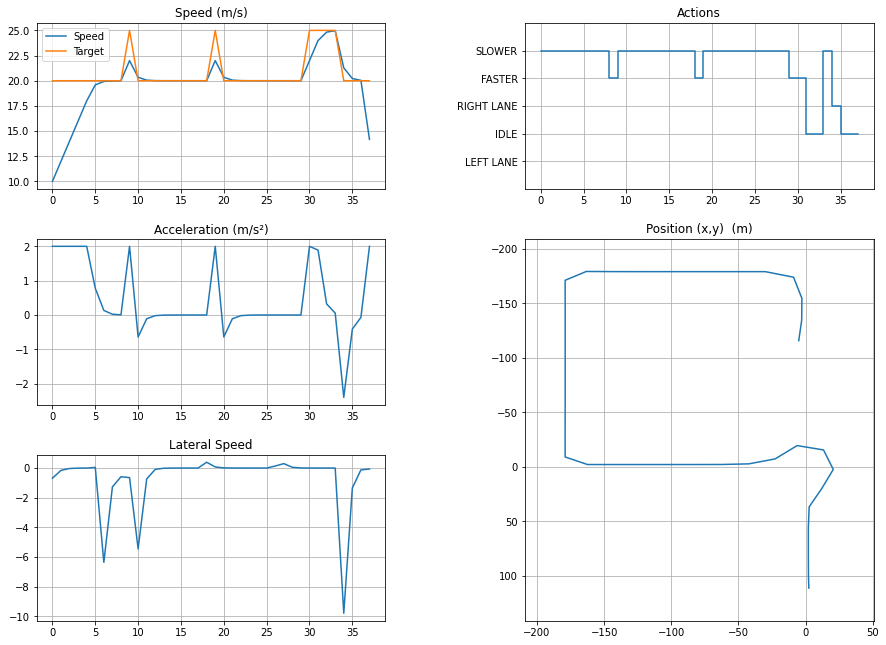

In [6]:
import gym
import highway_env
from stable_baselines3 import DQN
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

env = gym.make("roundabout-v131")
# model = DQN('MlpPolicy', env,
#               policy_kwargs=dict(net_arch=[256, 256]),
#               learning_rate=5e-4,
#               buffer_size=15000,
#               learning_starts=200,
#               batch_size=32,
#               gamma=0.8,
#               train_freq=1,
#               gradient_steps=1,
#               target_update_interval=50,
#               verbose=1,
#               tensorboard_log="highway_dqn/")
# model.learn(int(2e4))
# model.save("highway_dqn/model")
# Make environment
env = record_videos(env)

actions = []


vel = []
target_vel=[]
acc=[]
pos=[]
lat_vel=[]

action_names = ['LEFT LANE','IDLE','RIGHT LANE','FASTER','SLOWER']
df = pd.DataFrame(columns = ['vehicle', 'x','y','vx','vy'])
# Load and test saved model
model = DQN.load("/content/highway-env/highway_dqn/model.zip")
done = False
t = 0
while done == False:
  done = False
  obs = env.reset()
  while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    actions.append(action)
    #env.render()
    dft = pd.DataFrame(obs,columns = ['vehicle', 'x','y','vx','vy'])
    df = df.append(dft)
    
    v, tv, ac, p, lv = env.vehicleInfo()
    vel.append(v)
    target_vel.append(tv)
    acc.append(ac)
    pos.append([p[0],p[1]])
    lat_vel.append(lv)

    t+=1
        
env.close()
show_videos()

step = np.arange(len(actions)) 
pos_ = np.array([np.array(xi) for xi in pos])

fig = plt.figure(figsize=(15, 11))

grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.title('Speed (m/s)')
plt.plot(range(t),vel,label = "Speed")
plt.plot(range(t), target_vel, label = "Target")
plt.legend()
plt.grid()

plt.subplot(grid[2, 0])
plt.title('Lateral Speed')
plt.plot(range(t),lat_vel)
# plt.plot(ran_t,steering_angle, label = "Target")
# plt.legend()
plt.grid()

plt.subplot(grid[1, 0])
plt.title('Acceleration (m/s²)')
plt.plot(range(t),acc)
plt.grid()

plt.subplot(grid[0, 1])
plt.title('Actions')
plt.yticks([0,1,2,3,4], action_names)
plt.step(range(t),actions)
plt.ylim(-1, 5) 
plt.grid()

x=pos_[:,0]
y=pos_[:,1]

plt.subplot(grid[1:, 1])
plt.title('Position (x,y)  (m)')
plt.plot(x,y)
plt.ylim(max(y)+30, min(y)-30)
plt.xlim(min(x)-30, max(x)+30)
plt.grid()

plt.show()